In [ ]:
# --- CSS STYLE ---
from IPython.core.display import HTML
def css_styling():
    styles = open("../input/styles/alerts.css", "r").read()
    
    return HTML("<style>"+styles+"</style>")
css_styling()

<h1><center>Breast Cancer - EDA and Binary Classification 📉🔍</center></h1>

<div class="alert success-alert">
<b>Breast cancer</b> is the most common invasive cancer in women and the second leading cause of cancer death in women after lung cancer.
    <br><br>It arises in the lining cells (epithelium) of the ducts (85%) or lobules (15%) in the glandular tissue of the breast. Initially, the cancerous growth is confined to the duct or lobule (“in situ”) where it generally causes no symptoms and has minimal potential for spread (metastasis).

<bR>Most types of breast cancer are easy to diagnose by microscopic analysis of a sample - or biopsy - of the affected area of the breast. Also, there are types of breast cancer that require specialized lab exams.
</div>

<div class="alert simple-alert">
🎯 <b>Goal</b>: Conduct comprehensive EDA on this dataset. And later, build a binary classification model to predict the diagnosis as M = malignant or B = benign.



In [ ]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import plotly.express as px
from sklearn.cluster import KMeans
from skimage import morphology, measure
from skimage import morphology, measure

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv("../input/breast-cancer-wisconsin-data/data.csv")
data.head()

<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>1. EDA and Preprocessing 🔍 🛠</center></h1>

First off, there is an **'Unnamed'** column with no values. We will drop this column.

In [ ]:
data.drop('Unnamed: 32', axis = 1, inplace = True) # drop last unnamed empty column

Now, let's take a look at how our target column, <code>diagnosis</code>, is distributed.

In [ ]:
# Checking for the class imbalance
fig = plt.figure(figsize = (10, 6))
axis = sns.countplot(x = 'diagnosis', data = data);
axis.set_title('Class Distribution for the Target Feature', size = 20);

for patch in axis.patches:
    axis.text(x = patch.get_x() + patch.get_width()/2, y = patch.get_height()/2, 
            s = f"{np.round(patch.get_height()/len(data)*100, 1)}%", 
            ha = 'center', size = 40, rotation = 0, weight = 'bold' ,color = 'white')
    
axis.set_xlabel('Diagnosis', size = 14)
axis.set_ylabel('Count', size = 14);

Let's look at the basic statistics of the data.

In [ ]:
data.describe()

> <h4>📍 Points to be noted:</h4>
> 1. There are no missing values in the data. <br>
> 2. We don't have to consider the ID column for our classification analysis, which we will come to later on.<br>
> 3. The difference in range of the values of these features is very high. For example, the maximum value of <code>radius_mean</code> is <code>28.11</code>, for <code>perimeter_mean</code> it's <code>188.5</code>, and for <code>area_mean</code>, it goes all the way up to <code>2501</code>. We need to normalise the data to bring them to a uniform scale.

For the sake of simplicity in the upcoming steps, we are denoting all feature columns as <code>x</code> and the target column as <code>y</code>.

In [ ]:
y = data.diagnosis                          
list = ['id','diagnosis']
x = data.drop(list, axis = 1)

## Feature Scaling ⚖

Machine learning algorithms like linear regression, logistic regression, neural network, etc. that use **gradient descent** as an optimization technique require data to be scaled. Take a look at the formula for gradient descent below:

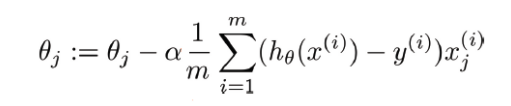

The presence of feature value X in the formula will affect the step size of the gradient descent. The difference in ranges of features will cause different step sizes for each feature. To ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features, we scale the data before feeding it to the model.

<br>For feature scaling, we will use ***standardization***, a scaling technique where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero and the resultant distribution has a unit standard deviation.<br>


You can read more about standardisation and normalisation, another scaling technique, in this [great article](https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/).

In [ ]:
x_standard = (x - x.mean()) / (x.std()) # x standardised

<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>2. Feature Selection 📊</center></h1>

In [ ]:
x_standard.columns

> The mean, standard error and "worst" or largest (mean of the three largest values) of all features were computed for each image, resulting in 30 features. So we can group the columns by these three categories resulting in groups of 10 simpler. This will make visualisations simpler. 

In [ ]:
mean_cols = [col for col in x_standard.columns if '_mean' in col]
se_cols = [col for col in x_standard.columns if '_se' in col]
worst_cols = [col for col in x_standard.columns if '_worst' in col]

<h3>Pairplots</h3>

These plots show the distribution of the observations based on two features and how they can be differentiated according to the target column. The diagonals show the degree of separation of a single feature in relation to the target column and what is the extent of overlap of the two classes of the target columns (M and B).

In [ ]:
df = pd.concat([y,x_standard[mean_cols]],axis=1)

ax = sns.pairplot(df, hue="diagnosis")
handles = ax._legend_data.values()
labels = ax._legend_data.keys()
ax.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=1)

***Graph Interpretation:*** <br>
For <code>area_mean</code>, <code>perimeter_mean</code>, <code>concave.points_mean</code> we have good separations. But there is a superposition in the case of <code>fractal_dimension_mean</code>.

In [ ]:
df = pd.concat([y,x_standard[se_cols]],axis=1)

ax = sns.pairplot(df, hue="diagnosis", palette="husl")
handles = ax._legend_data.values()
labels = ax._legend_data.keys()
ax.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=1)

***Graph Interpretation:*** <br>
We do have as well tight superposition for some of the values, like <code>symmetry_se</code>, <code>smoothness_se</code>. So these features might contribute less to our classification goal. 

In [ ]:
df = pd.concat([y,x_standard[worst_cols]],axis=1)

ax = sns.pairplot(df, hue="diagnosis", palette="Paired")
handles = ax._legend_data.values()
labels = ax._legend_data.keys()
ax.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=1)

***Graph Interpretation:*** <br>
Here, <code>radius_worst</code> and <code>perimeter_worst</code>. plots seem similar. And <code>concavity_worst</code> and <code>concavity.points_worst</code> as well. We can infer more information about the similarities when we check the correlation between features.

<h3>Correlation Matrix</h3>

In [ ]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(x_standard.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

<h4>📍 Inference</h4>

> * <code>radius</code>, <code>perimeter</code> and <code>area</code> (all three - 'mean', 'se' and 'worst') have high positive correlation among themselves and with number of concave points This is expected since as high values of these features are associated with malignancy.
> * <code>compactness</code>,  <code>concavity</code> and <code>concave.points</code> (all three - 'mean', 'se' and 'worst') have high positive correlation.
> * <code>texture_mean</code> and <code>texture_worst</code> are correlated.
> * <code>area_mean</code>, <code>area_worst</code> are perfectly correlated. <br>

The question is: *which variables to choose and which variables to discard?* To choose my features, I will look at the the **swarm plots** and try to decide which features will represent by data best.

<h3>Swarm Plots</h3>

***Swarm plot*** is a categorical scatterplot with non-overlapping points.<br>
This function is similar to stripplot(), but the points are adjusted (only along the categorical axis) so that they don’t overlap. This gives a better representation of the distribution of values, but it does not scale well to large numbers of observations. This style of plot is sometimes called a **“beeswarm”**.

In [ ]:
df = pd.concat([y,x_standard[mean_cols]],axis=1)
df = pd.melt(df ,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')

plt.figure(figsize=(10,10))
sns.swarmplot(x="features", y="value", hue="diagnosis", data=df)
plt.xticks(rotation=90)

In [ ]:
df = pd.concat([y,x_standard[se_cols]],axis=1)
df = pd.melt(df ,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')

plt.figure(figsize=(10,10))
sns.swarmplot(x="features", y="value", hue="diagnosis", data=df, palette="husl")
plt.xticks(rotation=90)

In [ ]:
df = pd.concat([y,x_standard[worst_cols]],axis=1)
df = pd.melt(df ,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')

plt.figure(figsize=(10,10))
sns.swarmplot(x="features", y="value", hue="diagnosis", data=df, palette="Paired")
plt.xticks(rotation=90)

<h4>📍 Feature Selection</h4>

> * Looking at the <code>radius</code>, <code>perimeter</code> and <code>area</code> in all three swarm plots, I can choose <code>area_mean</code>, <code>area_se</code> and <code>area_worst</code>. Bceause 'B' and 'M' observations look separated for <code>area</code> features, for the most part.
> * Similarly, for <code>compactness</code>,  <code>concavity</code> and <code>concave.points</code>, I will choose  <code>concavity_mean</code>, <code>concavity_se</code> and <code>concavity_worst</code>.
> * Between <code>area_mean</code> and <code>area_worst</code>, I will choose <code>area_mean</code>.
> * And between, <code>texture_mean</code> and <code>texture_worst</code>, I will go with <code>texture_mean</code>.
> 

In [ ]:
# Dropping coloumns according to the conclusion in the paragraph above.

drop_columns = ["radius_se", "radius_mean", "radius_worst", 
               "perimeter_se", "perimeter_mean", "perimeter_worst",
               "compactness_se", "compactness_mean", "compactness_worst",
               "concave points_se", "concave points_mean", "concave points_worst",
               "area_worst", "texture_worst"]

x_final = x_standard.drop(drop_columns, axis=1)

In [ ]:
x_final.head()

We will now fit a binary classification model to this new datatset. We are going to use **XGBoost**.

In [ ]:
# Installing necessary libraries

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [ ]:
# split data into train and test sets
seed = 10
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(x_final, y, test_size=test_size, random_state=seed)

In [ ]:
model = XGBClassifier()
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
cm = confusion_matrix(y_test, y_pred)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['B', 'M']); ax.yaxis.set_ticklabels(['M', 'B']);

We are getting and accuracy of 97%. The confusion matrix gives us a more holistic view of how well our classification model is performing and what kinds of errors it is making. As we can see, we are getting 5 wrong predictions.

We can use other feature selection methods and check how our classifier performs.

> <h3>This notebook is a work in progress.</h3>